In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import progressbar
import astropy.cosmology as apc
from sphviewer.tools import QuickView
from sphviewer.tools import Blend
import scipy.stats as sp

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_backwards(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0: # i hope this still work
            break
        snap, idd = split_unique_id(int(node))
        snapT = str(snap-1)
        for s in succesors:
            if s.startswith(snapT):
                node = s # select the firts succesor from a previous snapshot
                break
        #node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 36)
pl.rc('legend', fontsize = 36)
pl.rc('axes', linewidth=1.5)
#sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
#trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')
sim = h5py.File('/disk1/lbignone/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/lbignone/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [5]:
# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp

In [6]:
# ok, the preliminaries, lets see time first
Dtime, Nsnap = [], []

for i in range(30, 129):
    Nsnap.append(i)
    z = sim['SnapNumber_{}/Header/Redshift'.format(i)][()]
    Time = Cosmo.lookback_time(z).value
    Dtime.append(Time)
    
Dtime, Nsnap = np.array(Dtime), np.array(Nsnap)

In [7]:
Dtime2 = Dtime[:-2] - Dtime[1:-1]
Nsnap2 = Nsnap[1:-1]

In [8]:
Dtime2

array([0.02021814, 0.02167216, 0.02323088, 0.02490189, 0.0266933 ,
       0.02861383, 0.03067287, 0.03288046, 0.03524742, 0.03778535,
       0.04050675, 0.04342506, 0.04655469, 0.04991123, 0.05351142,
       0.05737333, 0.06151644, 0.06596179, 0.0707321 , 0.07585198,
       0.08134807, 0.08724919, 0.09358677, 0.09970028, 0.10086045,
       0.10095648, 0.10105792, 0.1011646 , 0.10127644, 0.10139329,
       0.10151498, 0.10164143, 0.10177251, 0.10190797, 0.10204777,
       0.10219172, 0.10233961, 0.10249133, 0.10264675, 0.10280564,
       0.10296782, 0.10313321, 0.10330159, 0.10347277, 0.10364657,
       0.10382291, 0.10400145, 0.10418225, 0.10436489, 0.10454938,
       0.10473549, 0.10492308, 0.10511189, 0.10530185, 0.10549274,
       0.10568456, 0.10587688, 0.10606974, 0.10626297, 0.10645633,
       0.10664981, 0.10684317, 0.10703632, 0.10722908, 0.10742138,
       0.10761304, 0.10780394, 0.10799407, 0.10818314, 0.10837126,
       0.10855809, 0.10874373, 0.10892794, 0.10911072, 0.10929

Text(0, 0.5, '$\\Delta$ Time/Gyrs h$^1$')

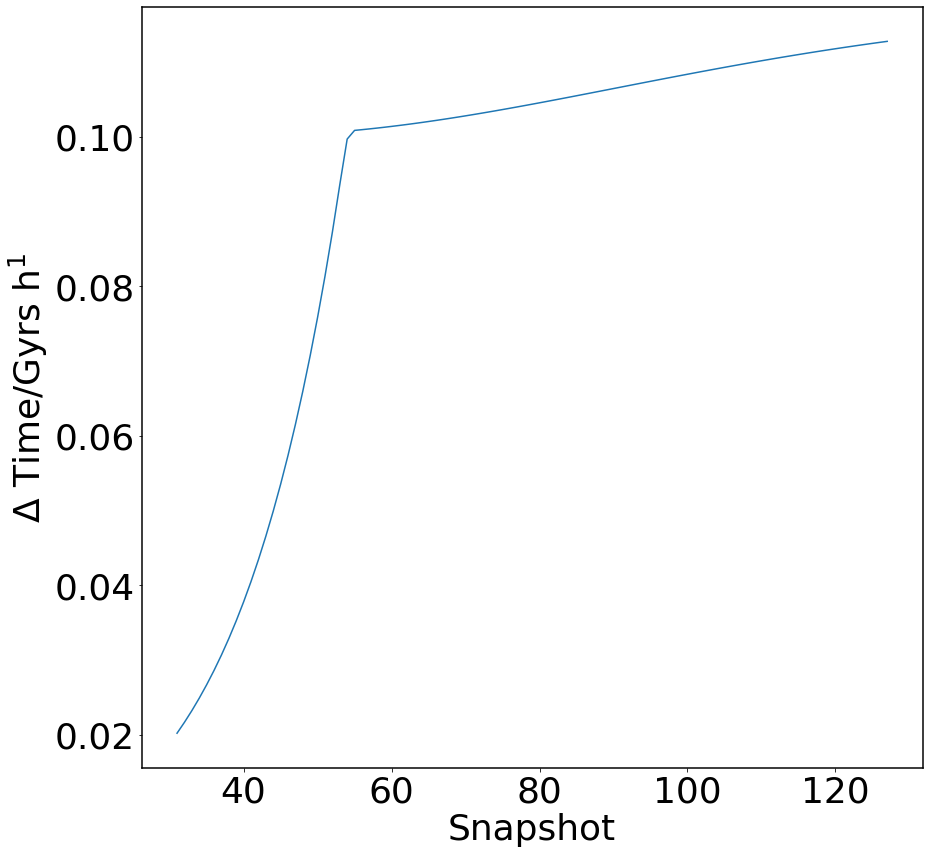

In [9]:
pl.figure(figsize=(14,14))

pl.plot(Nsnap2, Dtime2)

pl.xlabel('Snapshot')
pl.ylabel('$\Delta$ Time/Gyrs h$^1$')

In [10]:
# ok, star formation history
def getSFH(galID, cenID):
    offStar = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][galID].astype('int')
    pGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][galID]
    ropt = sim['SnapNumber_128/SubGroups/OpticalRadius'][galID]
        
    pstar = sim['SnapNumber_128/PartType4/Coordinates'][offStar[0]:offStar[1]]
    x, y, z = pstar[:,0]-pGal[0], pstar[:,1]-pGal[1], pstar[:,2]-pGal[2]
    r = np.sqrt(x**2+y**2+z**2)
    ik = np.where(r<ropt)
    index = np.arange(offStar[0],offStar[1])[ik]
    
    masses = sim['SnapNumber_128/PartType4/Masses'][index]
    times = sim['SnapNumber_128/PartType4/StellarFormationTime'][index]
    PhiTime = Cosmo.lookback_time(1./times -1.).value
    
    bmass, bedges, thing = sp.binned_statistic(PhiTime, masses, statistic='sum', bins=10)
    bx = .5*(bedges[:-1]+bedges[1:])
    bmass = bmass*1e10
    
    #ok, now to find the time of entering
    
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cenID]
    R200 =  sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
    TimeE = 0
    
    uniqueID = int(128*1e6+galID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    # and the centre
    uniqueIDC = int(128*1e6+cenID)
    streeC = networkx.dfs_tree(trees, str(uniqueIDC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueIDC))
    
    for m, mC in zip(mtree, mtreeC):
        snap, ffT = split_unique_id(int(m))
        snapC, ccT = split_unique_id(int(mC))
        
        gP = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ffT]
        gC = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][ccT]
        
        dist = np.sqrt(np.sum((gP-gC)**2.))
        if dist<R200:
            z = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
            TimeE =  Cosmo.lookback_time(z)
            
    return bx, bmass, TimeE.value

In [11]:
Time_4338, Mass_4338, TimeE_4338 = getSFH(4338, 4337)
Time_4339, Mass_4339, TimeE_4339 = getSFH(4339, 4337)
Time_4341, Mass_4341, TimeE_4341 = getSFH(4341, 4337)
Time_4343, Mass_4343, TimeE_4343 = getSFH(4343, 4337)

In [12]:
Time_4470, Mass_4470, TimeE_4470 = getSFH(4470, 4469)
Time_4471, Mass_4471, TimeE_4471 = getSFH(4471, 4469)
Time_4473, Mass_4473, TimeE_4473 = getSFH(4473, 4469)
Time_4474, Mass_4474, TimeE_4474 = getSFH(4474, 4469)

Text(0, 0.5, '$\\log($Stellar Mass$/M_{\\odot}$ h$^{-1}$)')

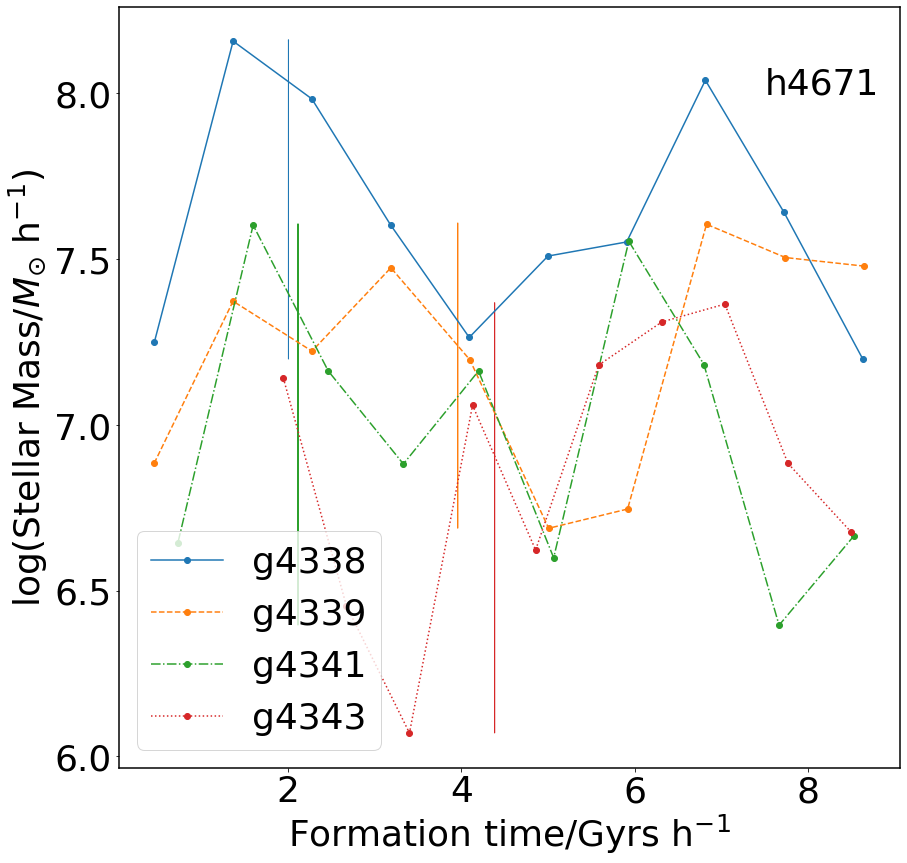

In [13]:
pl.figure(figsize=(14,14))

pl.plot(Time_4338, np.log10(Mass_4338), marker='o', ls='-', label='g4338')
pl.plot(Time_4339, np.log10(Mass_4339), marker='o', ls='--', label='g4339')
pl.plot(Time_4341, np.log10(Mass_4341), marker='o', ls='-.', label='g4341')
pl.plot(Time_4343, np.log10(Mass_4343), marker='o', ls=':', label='g4343')

pl.arrow(TimeE_4338, np.min(np.log10(Mass_4338)), 0., np.max(np.log10(Mass_4338))-np.min(np.log10(Mass_4338)), color='tab:blue', ls='-')
pl.arrow(TimeE_4339, np.min(np.log10(Mass_4339)), 0., np.max(np.log10(Mass_4339))-np.min(np.log10(Mass_4339)), color='tab:orange', ls='-')
pl.arrow(TimeE_4341, np.min(np.log10(Mass_4341)), 0., np.max(np.log10(Mass_4341))-np.min(np.log10(Mass_4341)), color='tab:green', ls='-')
pl.arrow(TimeE_4343, np.min(np.log10(Mass_4343)), 0., np.max(np.log10(Mass_4343))-np.min(np.log10(Mass_4343)), color='tab:red', ls='-')

pl.text(7.5, 8, 'h4671')

pl.legend(loc='best')

pl.xlabel('Formation time/Gyrs h$^{-1}$')
pl.ylabel('$\log($Stellar Mass$/M_{\odot}$ h$^{-1}$)')

Text(0, 0.5, '$\\log($Stellar Mass$/M_{\\odot}$ h$^{-1}$)')

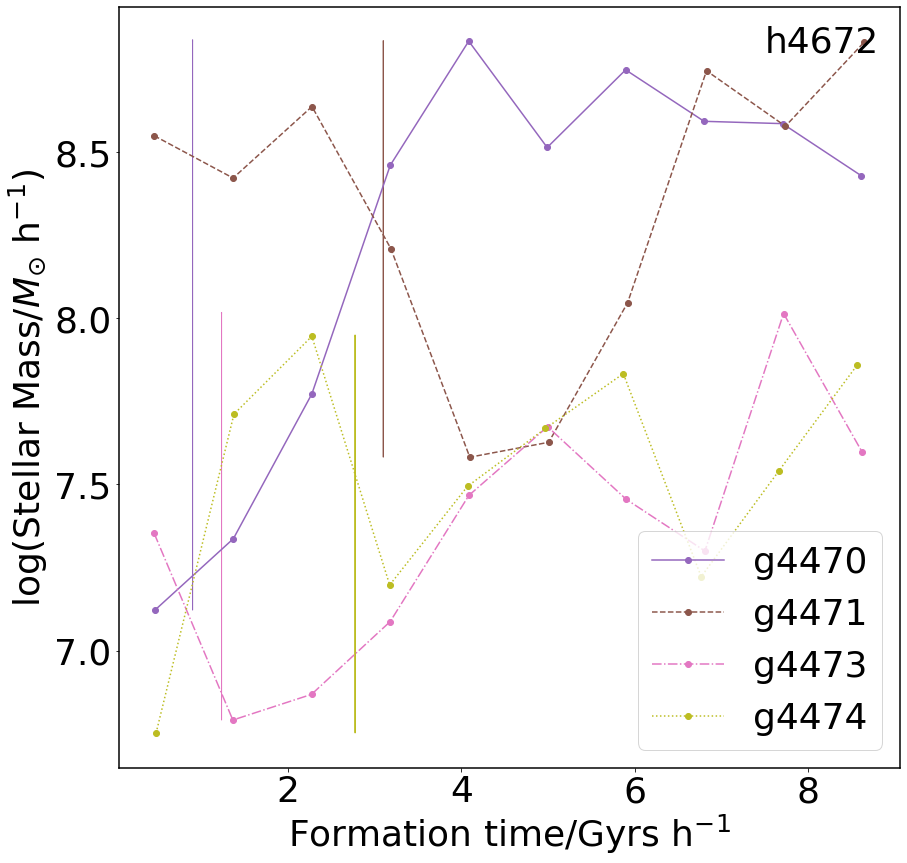

In [14]:
pl.figure(figsize=(14,14))

pl.plot(Time_4470, np.log10(Mass_4470), marker='o', ls='-', label='g4470', color='tab:purple')
pl.plot(Time_4471, np.log10(Mass_4471), marker='o', ls='--', label='g4471', color='tab:brown')
pl.plot(Time_4473, np.log10(Mass_4473), marker='o', ls='-.', label='g4473', color='tab:pink')
pl.plot(Time_4474, np.log10(Mass_4474), marker='o', ls=':', label='g4474', color='tab:olive')

pl.arrow(TimeE_4470, np.min(np.log10(Mass_4470)), 0., np.max(np.log10(Mass_4470))-np.min(np.log10(Mass_4470)), color='tab:purple', ls='-')
pl.arrow(TimeE_4471, np.min(np.log10(Mass_4471)), 0., np.max(np.log10(Mass_4471))-np.min(np.log10(Mass_4471)), color='tab:brown', ls='-')
pl.arrow(TimeE_4473, np.min(np.log10(Mass_4473)), 0., np.max(np.log10(Mass_4473))-np.min(np.log10(Mass_4473)), color='tab:pink', ls='-')
pl.arrow(TimeE_4474, np.min(np.log10(Mass_4474)), 0., np.max(np.log10(Mass_4474))-np.min(np.log10(Mass_4474)), color='tab:olive', ls='-')

pl.text(7.5, 8.8, 'h4672')

pl.legend(loc='best')

pl.xlabel('Formation time/Gyrs h$^{-1}$')
pl.ylabel('$\log($Stellar Mass$/M_{\odot}$ h$^{-1}$)')

In [15]:
# ok, now lets take a look at densities vs tiem for a little.

T = h5py.File('Derived_Data_2.h5', 'r')

dist_4338 = T['g4338/distance'][()]
Time_4338 = T['g4338/time'][()]
cosC_4338 = T['g4338/CosCen'][()]
cosV_4338 = T['g4338/CosVel'][()]
RP_4338 = T['g4338/RP'][()]
TSt_4338 = T['g4338/TSt'][()]
gMass_4338 = T['g4338/gMass'][()]
SFR_4338 = T['g4338/SFR'][()]
starMass_4338 = T['g4338/starMass'][()]
Gas_4338 = T['g4338/Gas'][()]
RestForce_4338 = T['g4338/RestForce'][()]

dist_4339 = T['g4339/distance'][()]
Time_4339 = T['g4339/time'][()]
cosC_4339 = T['g4339/CosCen'][()]
cosV_4339 = T['g4339/CosVel'][()]
RP_4339 = T['g4339/RP'][()]
TSt_4339 = T['g4339/TSt'][()]
gMass_4339 = T['g4339/gMass'][()]
SFR_4339 = T['g4339/SFR'][()]
starMass_4339 = T['g4339/starMass'][()]
Gas_4339 = T['g4339/Gas'][()]
RestForce_4339 = T['g4339/RestForce'][()]

dist_4341 = T['g4341/distance'][()]
Time_4341 = T['g4341/time'][()]
cosC_4341 = T['g4341/CosCen'][()]
cosV_4341 = T['g4341/CosVel'][()]
RP_4341 = T['g4341/RP'][()]
TSt_4341 = T['g4341/TSt'][()]
gMass_4341 = T['g4341/gMass'][()]
SFR_4341 = T['g4341/SFR'][()]
starMass_4341 = T['g4341/starMass'][()]
Gas_4341 = T['g4341/Gas'][()]
RestForce_4341 = T['g4341/RestForce'][()]

dist_4343 = T['g4343/distance'][()]
Time_4343 = T['g4343/time'][()]
cosC_4343 = T['g4343/CosCen'][()]
cosV_4343 = T['g4343/CosVel'][()]
RP_4343 = T['g4343/RP'][()]
TSt_4343 = T['g4343/TSt'][()]
gMass_4343 = T['g4343/gMass'][()]
SFR_4343 = T['g4343/SFR'][()]
starMass_4343 = T['g4343/starMass'][()]
Gas_4343 = T['g4343/Gas'][()]
RestForce_4343 = T['g4343/RestForce'][()]

dist_4470 = T['g4470/distance'][()]
Time_4470 = T['g4470/time'][()]
cosC_4470 = T['g4470/CosCen'][()]
cosV_4470 = T['g4470/CosVel'][()]
RP_4470 = T['g4470/RP'][()]
TSt_4470 = T['g4470/TSt'][()]
gMass_4470 = T['g4470/gMass'][()]
SFR_4470 = T['g4470/SFR'][()]
starMass_4470 = T['g4470/starMass'][()]
Gas_4470 = T['g4470/Gas'][()]
RestForce_4470 = T['g4470/RestForce'][()]

dist_4471 = T['g4471/distance'][()]
Time_4471 = T['g4471/time'][()]
cosC_4471 = T['g4471/CosCen'][()]
cosV_4471 = T['g4471/CosVel'][()]
RP_4471 = T['g4471/RP'][()]
TSt_4471 = T['g4471/TSt'][()]
gMass_4471 = T['g4471/gMass'][()]
SFR_4471 = T['g4471/SFR'][()]
starMass_4471 = T['g4471/starMass'][()]
Gas_4471 = T['g4471/Gas'][()]
RestForce_4471 = T['g4471/RestForce'][()]

dist_4473 = T['g4473/distance'][()]
Time_4473 = T['g4473/time'][()]
cosC_4473 = T['g4473/CosCen'][()]
cosV_4473 = T['g4473/CosVel'][()]
RP_4473 = T['g4473/RP'][()]
TSt_4473 = T['g4473/TSt'][()]
gMass_4473 = T['g4473/gMass'][()]
SFR_4473 = T['g4473/SFR'][()]
starMass_4473 = T['g4473/starMass'][()]
Gas_4473 = T['g4473/Gas'][()]
RestForce_4473 = T['g4473/RestForce'][()]

dist_4474 = T['g4474/distance'][()]
Time_4474 = T['g4474/time'][()]
cosC_4474 = T['g4474/CosCen'][()]
cosV_4474 = T['g4474/CosVel'][()]
RP_4474 = T['g4474/RP'][()]
TSt_4474 = T['g4474/TSt'][()]
gMass_4474 = T['g4474/gMass'][()]
SFR_4474 = T['g4474/SFR'][()]
starMass_4474 = T['g4474/starMass'][()]
Gas_4474 = T['g4474/Gas'][()]
RestForce_4474 = T['g4474/RestForce'][()]

In [16]:
T2 = h5py.File('Densities.h5', 'r')

Dens_4338 = T2['g4338/Densities'][()]
Dens_4339 = T2['g4339/Densities'][()]
Dens_4341 = T2['g4341/Densities'][()]
Dens_4343 = T2['g4343/Densities'][()]

Dens_4470 = T2['g4470/Densities'][()]
Dens_4471 = T2['g4471/Densities'][()]
Dens_4473 = T2['g4473/Densities'][()]
Dens_4474 = T2['g4474/Densities'][()]

Dens_4338 = Dens_4338[1:]
Dens_4339 = Dens_4339[1:]
Dens_4341 = Dens_4341[1:]
Dens_4343 = Dens_4343[1:]

Dens_4470 = Dens_4470[1:]
Dens_4471 = Dens_4471[1:]
Dens_4473 = Dens_4473[1:]
Dens_4474 = Dens_4474[1:]

In [17]:
Dens_4338.size, Time_4338.size

(85, 25)

In [18]:
Dens_4471

array([4.03864063e-18, 4.00470992e-18, 3.93427317e-18, 4.07813869e-18,
       3.73033984e-18, 3.56114790e-18, 3.96078032e-18, 4.18420835e-18,
       3.68695568e-18, 3.47078244e-18, 3.38401903e-18, 4.50047943e-18,
       4.88887833e-18, 3.55197080e-18, 2.48804749e-18, 3.02168044e-18,
       3.28104063e-18, 3.19961891e-18, 3.37877189e-18, 4.23030903e-18,
       5.25027000e-18, 7.87367648e-18, 9.66187505e-18, 8.07264993e-18,
       6.97617236e-18, 5.93901995e-18, 5.13191144e-18, 4.04463364e-18,
       3.50189482e-18, 2.87668169e-18, 2.36378577e-18, 1.86940340e-18,
       1.55635823e-18, 1.33833060e-18, 1.06866511e-18, 9.16921178e-19,
       8.14705162e-19, 7.87172316e-19, 7.14629840e-19, 6.59059296e-19,
       5.70637909e-19, 4.60760104e-19, 3.92601129e-19, 3.49564204e-19,
       3.20797057e-19, 3.04557514e-19, 3.37391217e-19, 3.92294800e-19,
       4.27159549e-19, 4.37165102e-19, 4.31008303e-19, 4.17341932e-19,
       3.84423712e-19, 3.74890767e-19, 3.22274801e-19, 2.73383021e-19,
      

In [19]:
Time_4339

array([1.77635684e-15, 1.12770636e-01, 2.25406927e-01, 3.37906562e-01,
       4.50267207e-01, 5.62486400e-01, 6.74561895e-01, 7.86491174e-01,
       8.98272012e-01, 1.00990206e+00, 1.12137903e+00, 1.23270051e+00,
       1.34386433e+00, 1.45486825e+00, 1.56571011e+00, 1.67638765e+00,
       1.78689890e+00, 1.89724174e+00, 2.00741404e+00, 2.11741398e+00,
       2.22723968e+00, 2.33688914e+00, 2.44636077e+00, 2.55565273e+00,
       2.66476345e+00, 2.77369139e+00, 2.88243512e+00, 2.99099320e+00,
       3.09936446e+00, 3.20754761e+00, 3.31554168e+00, 3.42334562e+00,
       3.53095866e+00, 3.63838003e+00, 3.74560911e+00, 3.85264544e+00,
       3.95948861e+00, 4.06613842e+00, 4.17259475e+00, 4.27885772e+00,
       4.38492746e+00])

In [20]:
lim = 10**(-28.3)

Lim = lim/1000.*1e2*1e2*1e2
Lim

5.0118723362727145e-26

Text(0, 0.5, 'log(Densities/kg m$^{-3}$)')

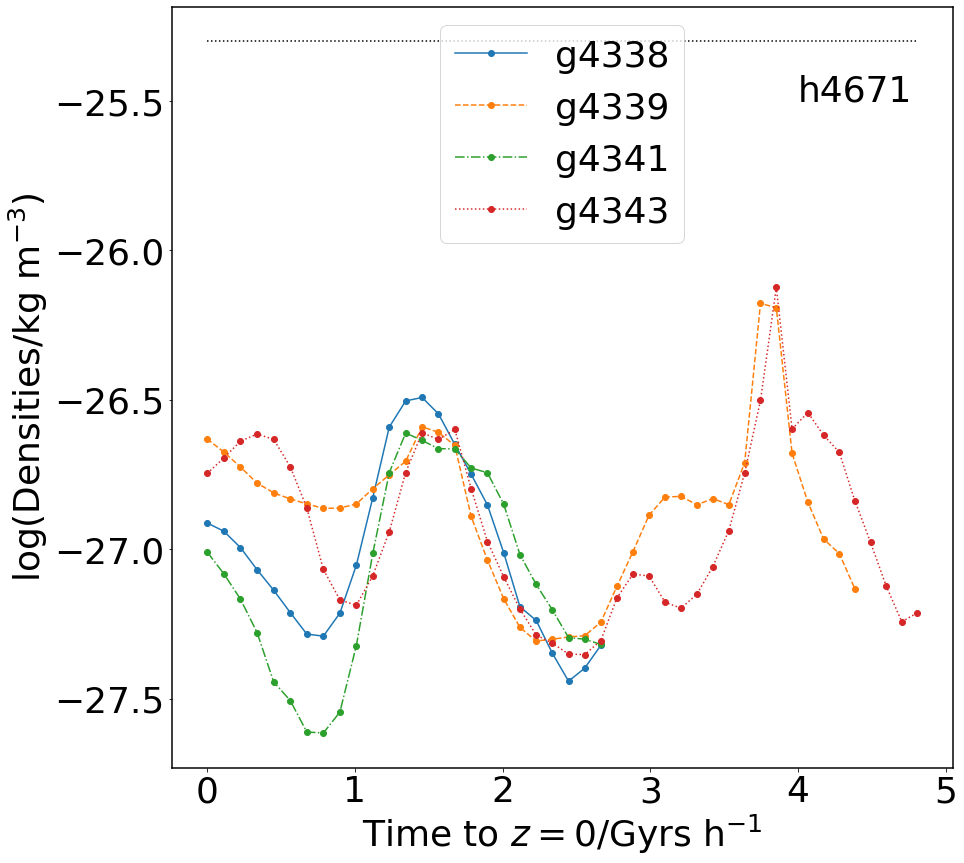

In [21]:
pl.figure(figsize=(14,14))

pl.plot(Time_4338, np.log10(Dens_4338[:Time_4338.size]/1e9), marker='o', ls='-', label='g4338')
pl.plot(Time_4339, np.log10(Dens_4339[:Time_4339.size]/1e9), marker='o', ls='--', label='g4339')
pl.plot(Time_4341, np.log10(Dens_4341[:Time_4341.size]/1e9), marker='o', ls='-.', label='g4341')
pl.plot(Time_4343, np.log10(Dens_4343[:Time_4343.size]/1e9), marker='o', ls=':', label='g4343')

tmax = np.max([Time_4338.max(), Time_4339.max(), Time_4341.max(), Time_4343.max()])
pl.plot([0, tmax], [np.log10(Lim), np.log10(Lim)], ls=':', color='black')

pl.text(4, -25.5, 'h4671')

pl.legend(loc='best')

pl.xlabel('Time to $z=0$/Gyrs h$^{-1}$')
pl.ylabel('log(Densities/kg m$^{-3}$)')

Text(0, 0.5, 'log(Densities/kg m$^{-3}$)')

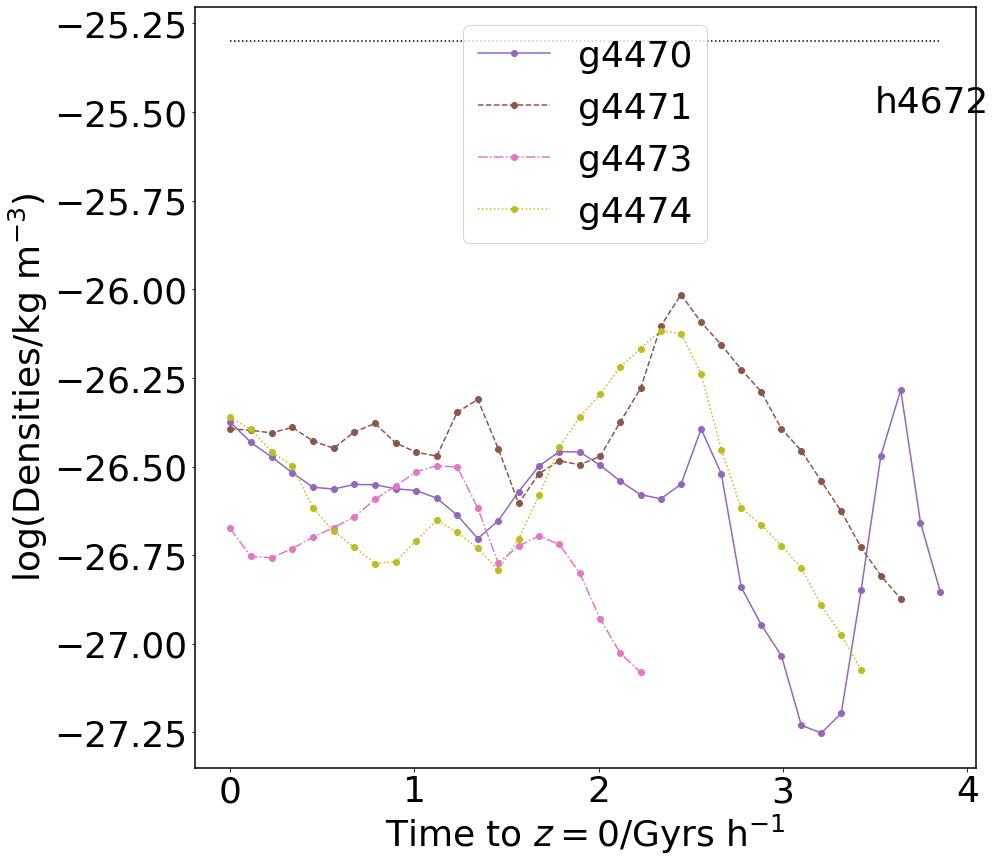

In [22]:
pl.figure(figsize=(14,14))

pl.plot(Time_4470, np.log10(Dens_4470[:Time_4470.size]/1e9), marker='o', ls='-', label='g4470', color='tab:purple')
pl.plot(Time_4471, np.log10(Dens_4471[:Time_4471.size]/1e9), marker='o', ls='--', label='g4471', color='tab:brown')
pl.plot(Time_4473, np.log10(Dens_4473[:Time_4473.size]/1e9), marker='o', ls='-.', label='g4473', color='tab:pink')
pl.plot(Time_4474, np.log10(Dens_4474[:Time_4474.size]/1e9), marker='o', ls=':', label='g4474', color='tab:olive')

tmax = np.max([Time_4470.max(), Time_4471.max(), Time_4473.max(), Time_4474.max()])
pl.plot([0, tmax], [np.log10(Lim), np.log10(Lim)], ls=':', color='black')

pl.text(3.5, -25.5, 'h4672')

pl.legend(loc='best')

pl.xlabel('Time to $z=0$/Gyrs h$^{-1}$')
pl.ylabel('log(Densities/kg m$^{-3}$)')

In [23]:
# ok lets take a look at the density of the hot particles.
Msun = 1.988*1e30
kpc = 3.086*1e19

def getDens_group(group):
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    offGroup = sim['SnapNumber_128/Groups/PartType0/Offsets'][group].astype('int')
    posGroup = sim['SnapNumber_128/Groups/GroupCM'][group]
    postPart = sim['SnapNumber_128/PartType0/Coordinates'][offGroup[0]:offGroup[1]]
    
    x, y, z = postPart[:,0] - posGroup[0], postPart[:,1] - posGroup[1], postPart[:,2] - posGroup[2]
    r = np.sqrt(x**2+y**2+z**2)
    
    IE = sim['SnapNumber_128/PartType0/InternalEnergy'][offGroup[0]:offGroup[1]]
    Mass = sim['SnapNumber_128/PartType0/Masses'][offGroup[0]:offGroup[1]]
    Abund = sim['SnapNumber_128/PartType0/Abundances'][offGroup[0]:offGroup[1]]
    ne1 = sim['SnapNumber_128/PartType0/ElectronAbundance'][offGroup[0]:offGroup[1]]
    
    temp = tempFromMass(Mass, Abund, IE, ne1)
    iK = np.where(temp>1e6)
    
    
    MassK = Mass[iK]
    rK = r[iK]

    SMass, Borders, stuff = sp.binned_statistic(rK, MassK, bins=20, range=(0, r200), statistic='sum')
    Vols = 4/3*np.pi*(Borders[1:]**3.-Borders[:-1]**3.)
        
    Dens = SMass*1e10/Vols # in M_sun/kcp^3
    Dens = Dens*Msun/(kpc**3.) # in kg/m^3, because, well
    Xs = 0.5*(Borders[1:]+Borders[:-1])
    Xs = Xs/r200
    return Xs, Dens

In [24]:
Xs_4671, Dens_4671 = getDens_group(4671)

In [25]:
Xs_4672, Dens_4672 = getDens_group(4672)

Text(0, 0.5, 'log(Density/kg m$^{-3}$)')

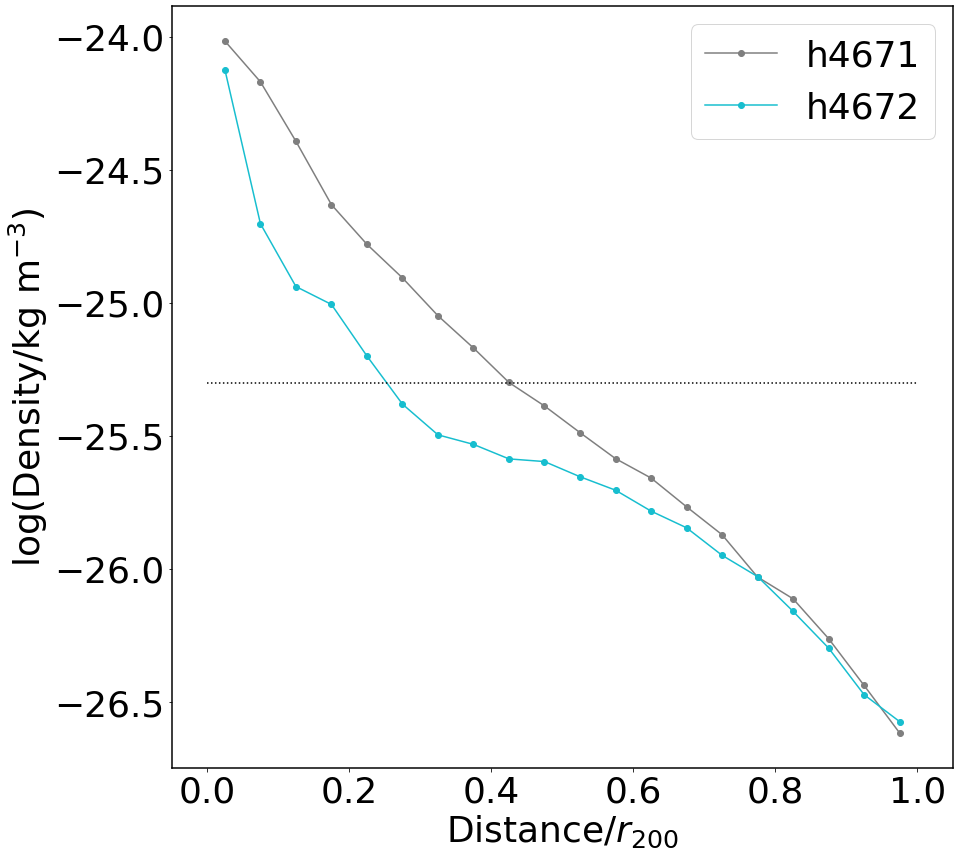

In [26]:
pl.figure(figsize=(14,14))

pl.plot(Xs_4671, np.log10(Dens_4671), marker='o', color='tab:grey', label='h4671')
pl.plot(Xs_4672, np.log10(Dens_4672), marker='o', color='tab:cyan', label='h4672')

pl.plot([0., 1.], [np.log10(Lim),np.log10(Lim)], ls=':', color='black')

pl.legend(loc='best')

pl.xlabel('Distance$/r_{200}$')
pl.ylabel('log(Density/kg m$^{-3}$)')

In [27]:
AA = sim['SnapNumber_128/SubGroups/SubGroupMostBoundID'][()]

In [28]:
AA.size

6033

In [29]:
DMIDs = sim['SnapNumber_128/PartType1/ParticleIDs'][()]
StarIDs = sim['SnapNumber_128/PartType4/ParticleIDs'][()]
GasIds = sim['SnapNumber_128/PartType0/ParticleIDs'][()]

In [30]:
# for i, a in enumerate(AA):
#     if np.isin(a, GasIds):
#         print('it is Gas', i)
#         break

In [31]:
# and niw we look for teh first pericenter
# local mimimums, a lots of them
def LocalMin(dist, Time):
    i = []
    for j, d in enumerate(dist):
        if j!=0 and j!=dist.size-1:
            if d<dist[j+1] and d<dist[j-1]:
                i.append(j)
    i = np.array(i)
    if dist[0]<dist[i].min():
        i = list(i)
        i.append(0)
        i = np.array(i)
        
    il = i[-1]
    print(Time[il-3] - Time[il], Time[il]-Time[il+3])
    return Time[i], dist[i]

In [32]:
mtime_4338, mdist_4338 = LocalMin(dist_4338, Time_4338)
mtime_4339, mdist_4339 = LocalMin(dist_4339, Time_4339)
mtime_4341, mdist_4341 = LocalMin(dist_4341, Time_4341)
mtime_4343, mdist_4343 = LocalMin(dist_4343, Time_4343)

mtime_4470, mdist_4470 = LocalMin(dist_4470, Time_4470)
mtime_4471, mdist_4471 = LocalMin(dist_4471, Time_4471)
mtime_4473, mdist_4473 = LocalMin(dist_4473, Time_4473)
mtime_4474, mdist_4474 = LocalMin(dist_4474, Time_4474)

-0.33300960474665864 -0.33153163275004793
-0.3228383584953889 -0.32110857381637636
-0.33203065195243564 -0.330515078027231
-0.3205293085933487 -0.3187890383308547
3.6383800349373283 -0.33790656159120047
-0.3278743163324007 -0.32622975274669486
-0.33665533353529753 -0.3353401662582183
3.2075476050576563 -0.33790656159120047


In [33]:
def Vartime(galID, mtime, ftime):
    offStar = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][galID].astype('int')
    pGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][galID]
    ropt = sim['SnapNumber_128/SubGroups/OpticalRadius'][galID]
        
    pstar = sim['SnapNumber_128/PartType4/Coordinates'][offStar[0]:offStar[1]]
    x, y, z = pstar[:,0]-pGal[0], pstar[:,1]-pGal[1], pstar[:,2]-pGal[2]
    r = np.sqrt(x**2+y**2+z**2)
    ik = np.where(r<ropt)
    index = np.arange(offStar[0],offStar[1])[ik]
    
    masses = sim['SnapNumber_128/PartType4/Masses'][index]
    times = sim['SnapNumber_128/PartType4/StellarFormationTime'][index]
    PhiTime = Cosmo.lookback_time(1./times -1.).value
    
    totMass = np.sum(masses)
    i = np.where(PhiTime>=mtime)
    i_f = np.where(PhiTime>=ftime)
    
    Mp = np.sum(masses[i])
    Mf = np.sum(masses[i_f])
    
    return Mp/totMass, Mf/totMass

In [34]:
ptime_4338, ftime_4338 = np.max(mtime_4338), Time_4338[-1]
ptime_4339, ftime_4339 = np.max(mtime_4338), Time_4339[-1]
ptime_4341, ftime_4341 = np.max(mtime_4341), Time_4341[-1]
ptime_4343, ftime_4343 = np.max(mtime_4343), Time_4343[-1]

ptime_4470, ftime_4470 = np.max(mtime_4470), Time_4470[-1]
ptime_4471, ftime_4471 = np.max(mtime_4471), Time_4471[-1]
ptime_4473, ftime_4473 = np.max(mtime_4473), Time_4473[-1]
ptime_4474, ftime_4474 = np.max(mtime_4474), Time_4474[-1]

In [35]:
pApo_4338, pInf_4338 = Vartime(4338, ptime_4338, ftime_4338)
pApo_4339, pInf_4339 = Vartime(4339, ptime_4339, ftime_4339)
pApo_4341, pInf_4341 = Vartime(4341, ptime_4341, ftime_4341)
pApo_4343, pInf_4343 = Vartime(4343, ptime_4343, ftime_4343)

pApo_4470, pInf_4470 = Vartime(4470, ptime_4470, ftime_4470)
pApo_4471, pInf_4471 = Vartime(4471, ptime_4471, ftime_4471)
pApo_4473, pInf_4473 = Vartime(4473, ptime_4473, ftime_4473)
pApo_4474, pInf_4474 = Vartime(4474, ptime_4474, ftime_4474)

print(pApo_4338, pApo_4339, pApo_4341, pApo_4343)
print(pApo_4470, pApo_4471, pApo_4473, pApo_4474)

0.7841842 0.87174606 0.7813706 0.785379
0.8940417 0.6560879 0.94350445 0.7180138


Text(0, 0.5, 'Fraction of cumulative $M_{\\star}$ formed')

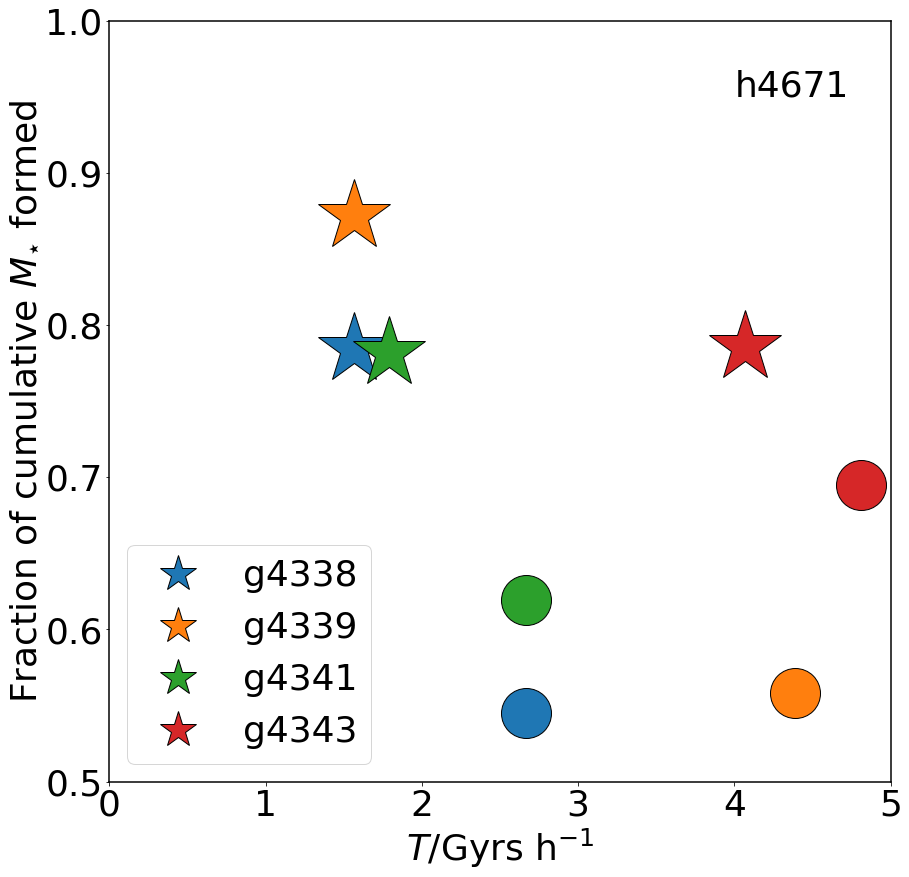

In [36]:
pl.figure(figsize=(14,14))

pl.plot(ptime_4338, pApo_4338, marker='*', markersize=75, color='tab:blue', label='g4338', ls=' ', mec='black')
pl.plot(ptime_4339, pApo_4339, marker='*', markersize=75, color='tab:orange', label='g4339', ls=' ', mec='black')
pl.plot(ptime_4341, pApo_4341, marker='*', markersize=75, color='tab:green', label='g4341', ls=' ', mec='black')
pl.plot(ptime_4343, pApo_4343, marker='*', markersize=75, color='tab:red', label='g4343', ls=' ', mec='black')

pl.plot(ftime_4338, pInf_4338, marker='o', markersize=50, color='tab:blue', ls=' ', mec='black')
pl.plot(ftime_4339, pInf_4339, marker='o', markersize=50, color='tab:orange', ls=' ', mec='black')
pl.plot(ftime_4341, pInf_4341, marker='o', markersize=50, color='tab:green', ls=' ', mec='black')
pl.plot(ftime_4343, pInf_4343, marker='o', markersize=50, color='tab:red', ls=' ', mec='black')

pl.text(4.,0.95,'h4671')

pl.xlim([0, 5])
pl.ylim([0.5, 1.])

pl.legend(loc=3, markerscale=0.5)
pl.xlabel('$T$/Gyrs h$^{-1}$')
pl.ylabel('Fraction of cumulative $M_{\star}$ formed')

Text(0, 0.5, 'Fraction of cumulative $M_{\\star}$ formed')

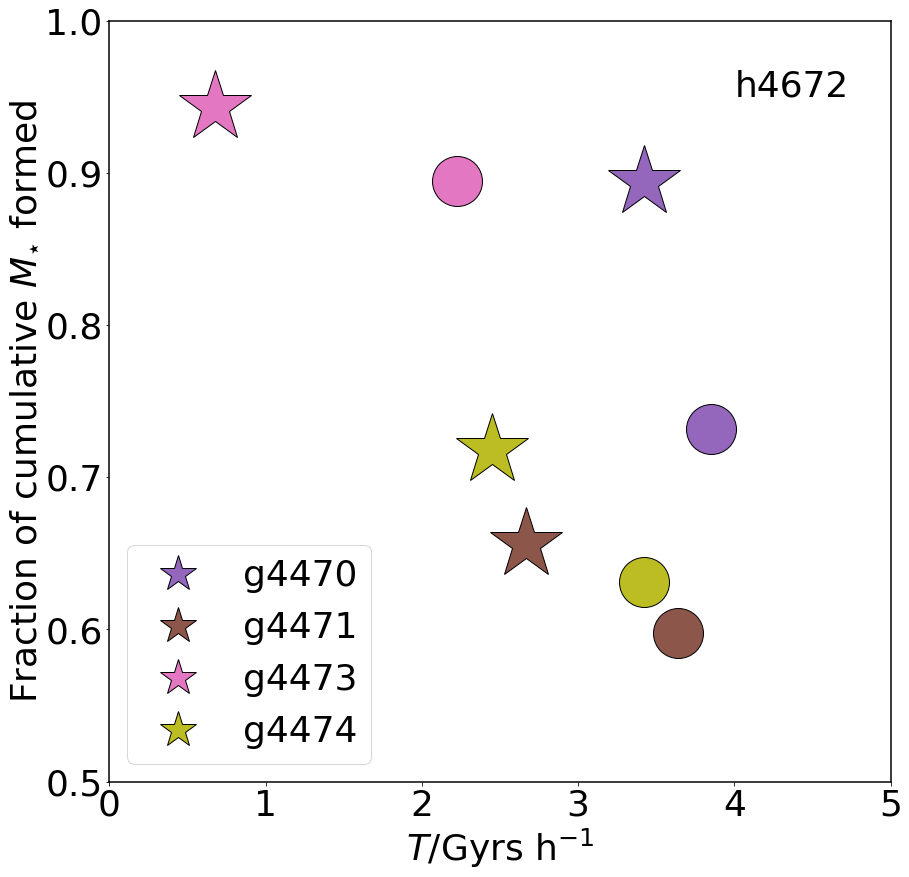

In [37]:
pl.figure(figsize=(14,14))

pl.plot(ptime_4470, pApo_4470, marker='*', markersize=75, color='tab:purple', label='g4470', ls=' ', mec='black')
pl.plot(ptime_4471, pApo_4471, marker='*', markersize=75, color='tab:brown', label='g4471', ls=' ', mec='black')
pl.plot(ptime_4473, pApo_4473, marker='*', markersize=75, color='tab:pink', label='g4473', ls=' ', mec='black')
pl.plot(ptime_4474, pApo_4474, marker='*', markersize=75, color='tab:olive', label='g4474', ls=' ', mec='black')

pl.plot(ftime_4470, pInf_4470, marker='o', markersize=50, color='tab:purple', ls=' ', mec='black')
pl.plot(ftime_4471, pInf_4471, marker='o', markersize=50, color='tab:brown', ls=' ', mec='black')
pl.plot(ftime_4473, pInf_4473, marker='o', markersize=50, color='tab:pink', ls=' ', mec='black')
pl.plot(ftime_4474, pInf_4474, marker='o', markersize=50, color='tab:olive', ls=' ', mec='black')

pl.xlim([0, 5])
pl.ylim([0.5, 1.])

pl.text(4.,0.95,'h4672')

pl.legend(loc='best', markerscale=0.5)
pl.xlabel('$T$/Gyrs h$^{-1}$')
pl.ylabel('Fraction of cumulative $M_{\star}$ formed')

In [38]:
# and look at the other things

In [39]:
def getFMass(gal, ftime):
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    f_mass = []
    for m in mtree:
        snap, idd = split_unique_id(int(m))
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        tt = Cosmo.lookback_time(zs).value
        if tt>ftime:
            break
        offG = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        offS = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        posGas = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][offG[0]:offG[1]]
        posStars = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][offS[0]:offS[1]]
        Ropt = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        
        Xg, Yg, Zg = posGas[:,0] - posGal[0], posGas[:,1] - posGal[1], posGas[:,2] - posGal[2]
        Xs, Ys, Zs = posStars[:,0] - posGal[0], posStars[:,1] - posGal[1], posStars[:,2] - posGal[2]
        
        rg = np.sqrt(Xg**2+Yg**2+Zg**2)/Ropt
        rs = np.sqrt(Xs**2+Ys**2+Zs**2)/Ropt
        
        igg = np.where(rg<=1)
        iss = np.where(rs<=1)
        
        aG = np.arange(offG[0], offG[1], 1)
        aS = np.arange(offS[0], offS[1], 1)
        
        aGi, aSi = aG[igg], aS[iss]
        
        massGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][aGi]
        massStar = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][aSi]
        
        f_mass.append(np.sum(massGas)/np.sum(massStar))
    return np.array(f_mass)[1:]

In [40]:
fmass_4338 = getFMass(4338, ftime_4338)
fmass_4339 = getFMass(4339, ftime_4339)
fmass_4341 = getFMass(4341, ftime_4341)
fmass_4343 = getFMass(4343, ftime_4343)

fmass_4470 = getFMass(4470, ftime_4470)
fmass_4471 = getFMass(4471, ftime_4471)
fmass_4473 = getFMass(4473, ftime_4473)
fmass_4474 = getFMass(4474, ftime_4474)

In [41]:
# local mimimums, a lots of them
def LocalMin(dist, Time):
    i = []
    for j, d in enumerate(dist):
        if j!=0 and j!=dist.size-1:
            if d<dist[j+1] and d<dist[j-1]:
                i.append(j)
    i = np.array(i)
    if dist[0]<dist[i].min():
        i = list(i)
        i.append(0)
        i = np.array(i)
    return Time[i], dist[i]

In [42]:
mtime_4338, mdist_4338 = LocalMin(dist_4338, Time_4338)
mtime_4339, mdist_4339 = LocalMin(dist_4339, Time_4339)
mtime_4341, mdist_4341 = LocalMin(dist_4341, Time_4341)
mtime_4343, mdist_4343 = LocalMin(dist_4343, Time_4343)

mtime_4470, mdist_4470 = LocalMin(dist_4470, Time_4470)
mtime_4471, mdist_4471 = LocalMin(dist_4471, Time_4471)
mtime_4473, mdist_4473 = LocalMin(dist_4473, Time_4473)
mtime_4474, mdist_4474 = LocalMin(dist_4474, Time_4474)

Text(0.5, 0, '$T_{z=0}$/Gyrs h$^{-1}$')

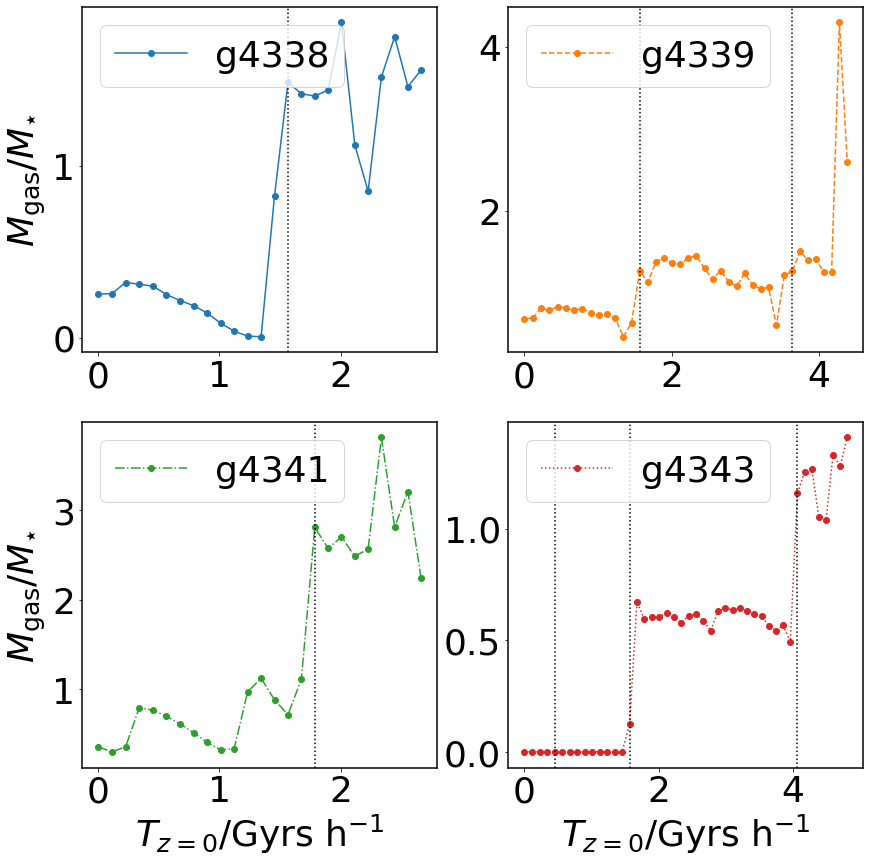

In [43]:
pl.figure(figsize=(14,14))

pl.subplot(2, 2, 1)
pl.plot(Time_4338, fmass_4338, marker='o', color='tab:blue', label='g4338', ls='-')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4338:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.ylabel('$M_{\\rm gas}/M_{\star}$')

pl.subplot(2, 2, 2)
pl.plot(Time_4339, fmass_4339, marker='o', color='tab:orange', label='g4339', ls='--')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4339:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.subplot(2, 2, 3)
pl.plot(Time_4341, fmass_4341, marker='o', color='tab:green', label='g4341', ls='-.')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4341:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)
pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')


pl.subplot(2, 2, 4)
pl.plot(Time_4343, fmass_4343, marker='o', color='tab:red', label='g4343', ls=':')
ylim = pl.ylim()
for t in mtime_4343:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.legend(loc='best')

# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')

Text(0.5, 0, '$T_{z=0}$/Gyrs h$^{-1}$')

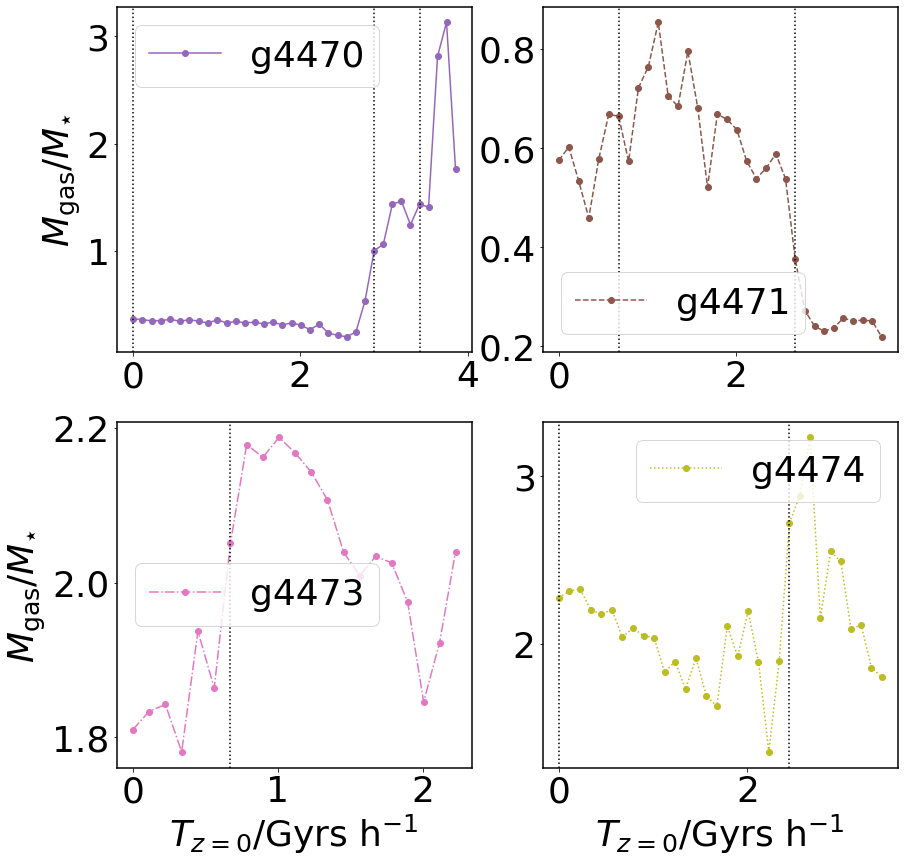

In [44]:
pl.figure(figsize=(14,14))

pl.subplot(2, 2, 1)
pl.plot(Time_4470, fmass_4470, marker='o', color='tab:purple', label='g4470', ls='-')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4470:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.ylabel('$M_{\\rm gas}/M_{\star}$')

pl.subplot(2, 2, 2)
pl.plot(Time_4471, fmass_4471, marker='o', color='tab:brown', label='g4471', ls='--')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4471:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.subplot(2, 2, 3)
pl.plot(Time_4473, fmass_4473, marker='o', color='tab:pink', label='g4473', ls='-.')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4473:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)
pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')


pl.subplot(2, 2, 4)
pl.plot(Time_4474, fmass_4474, marker='o', color='tab:olive', label='g4474', ls=':')
ylim = pl.ylim()
for t in mtime_4474:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.legend(loc='best')

# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')

In [45]:
def getGMass(gal, ftime):
    uniqueID = int(128*1e6+gal)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    Gmass, Smass, DMmass = [], [], []
    MHalo = []
    for m in mtree:
        snap, idd = split_unique_id(int(m))
        zs = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
        tt = Cosmo.lookback_time(zs).value
        if tt>ftime:
            break
        offG = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        offS = sim['SnapNumber_{}/SubGroups/PartType4/Offsets'.format(snap)][idd].astype('int')
        offDM = sim['SnapNumber_{}/SubGroups/PartType1/Offsets'.format(snap)][idd].astype('int')
        posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        posGas = sim['SnapNumber_{}/PartType0/Coordinates'.format(snap)][offG[0]:offG[1]]
        posStars = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][offS[0]:offS[1]]
        posDM = sim['SnapNumber_{}/PartType1/Coordinates'.format(snap)][offDM[0]:offDM[1]]
        Ropt = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]
        
        Xg, Yg, Zg = posGas[:,0] - posGal[0], posGas[:,1] - posGal[1], posGas[:,2] - posGal[2]
        Xs, Ys, Zs = posStars[:,0] - posGal[0], posStars[:,1] - posGal[1], posStars[:,2] - posGal[2]
        Xd, Yd, Zd = posDM[:,0] - posGal[0], posDM[:,1] - posGal[1], posDM[:,2] - posGal[2]
        
        rg = np.sqrt(Xg**2+Yg**2+Zg**2)/Ropt
        rs = np.sqrt(Xs**2+Ys**2+Zs**2)/Ropt
        rd = np.sqrt(Xd**2+Yd**2+Zd**2)/Ropt
        
        igg = np.where(rg<=1)
        iss = np.where(rs<=1)
        idds = np.where(rd<=1)
        
        aG = np.arange(offG[0], offG[1], 1)
        aS = np.arange(offS[0], offS[1], 1)
        
        aGi, aSi = aG[igg], aS[iss]
        
        massGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][aGi]
        massStar = sim['SnapNumber_{}/PartType4/Masses'.format(snap)][aSi]
        
        dmmas = sim['SnapNumber_{}/Header/MassTable'.format(snap)][1]
        massDM = idds[0].size*dmmas*1e10
        
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][idd]
        M200 = sim['SnapNumber_{}/Groups/Group_M_Crit200'.format(snap)][group]
        
        Gmass.append(np.sum(massGas)*1e10)
        Smass.append(np.sum(massStar)*1e10)
        DMmass.append(massDM)
        MHalo.append(M200*1e10)
        
    return np.array(Gmass)[1:], np.array(Smass)[1:], np.array(DMmass)[1:], np.array(MHalo)[1:]

In [46]:
Gmass_4338, Smass_4338, DMmass_4338, MHalo_4338 = getGMass(4338, ftime_4338)
Gmass_4339, Smass_4339, DMmass_4339, MHalo_4339 = getGMass(4339, ftime_4339)
Gmass_4341, Smass_4341, DMmass_4341, MHalo_4341 = getGMass(4341, ftime_4341)
Gmass_4343, Smass_4343, DMmass_4343, MHalo_4343 = getGMass(4343, ftime_4343)

Gmass_4470, Smass_4470, DMmass_4470, MHalo_4470 = getGMass(4470, ftime_4470)
Gmass_4471, Smass_4471, DMmass_4471, MHalo_4471 = getGMass(4471, ftime_4471)
Gmass_4473, Smass_4473, DMmass_4473, MHalo_4473 = getGMass(4473, ftime_4473)
Gmass_4474, Smass_4474, DMmass_4474, MHalo_4474 = getGMass(4474, ftime_4474)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0, '$T_{z=0}$/Gyrs h$^{-1}$')

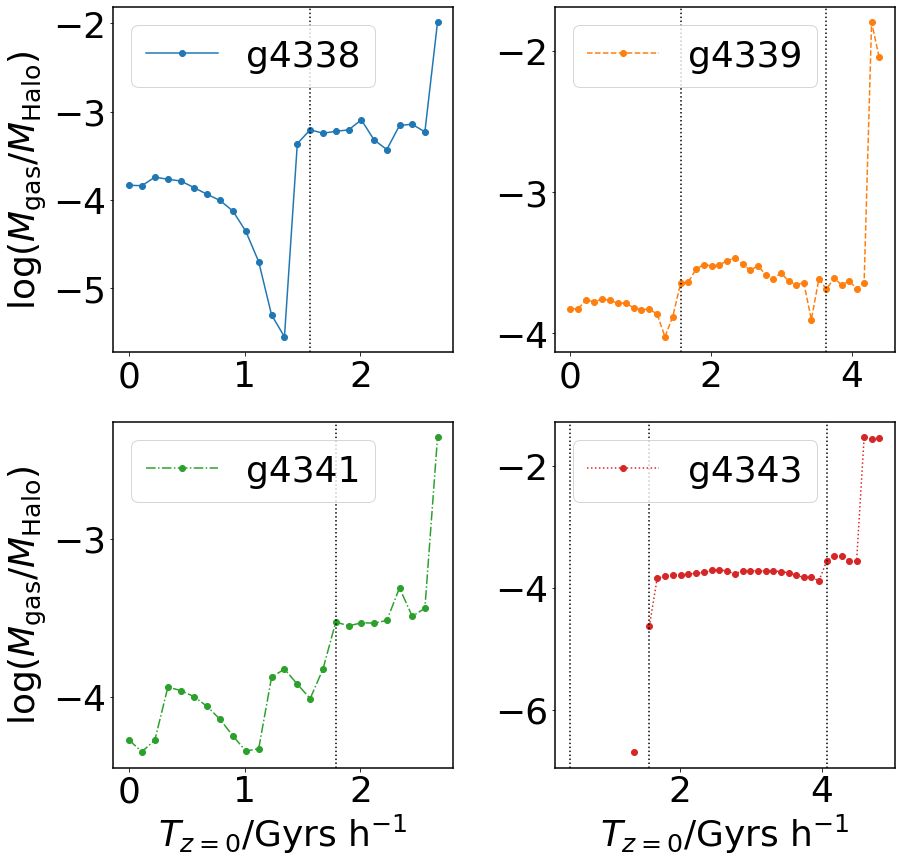

In [47]:
pl.figure(figsize=(14,14))

pl.subplots_adjust(wspace=.3)

pl.subplot(2, 2, 1)
pl.plot(Time_4338, np.log10(Gmass_4338/MHalo_4338), marker='o', color='tab:blue', label='g4338', ls='-')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4338:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.ylabel('$\\log(M_{\\rm gas}/M_{\\rm Halo})$')

pl.subplot(2, 2, 2)
pl.plot(Time_4339, np.log10(Gmass_4339/MHalo_4339), marker='o', color='tab:orange', label='g4339', ls='--')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4339:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.subplot(2, 2, 3)
pl.plot(Time_4341, np.log10(Gmass_4341/MHalo_4341), marker='o', color='tab:green', label='g4341', ls='-.')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4341:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)
pl.ylabel('$\\log(M_{\\rm gas}/M_{\\rm Halo})$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')


pl.subplot(2, 2, 4)
pl.plot(Time_4343, np.log10(Gmass_4343/MHalo_4343), marker='o', color='tab:red', label='g4343', ls=':')
ylim = pl.ylim()
for t in mtime_4343:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.legend(loc='best')

# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')

Text(0.5, 0, '$T_{z=0}$/Gyrs h$^{-1}$')

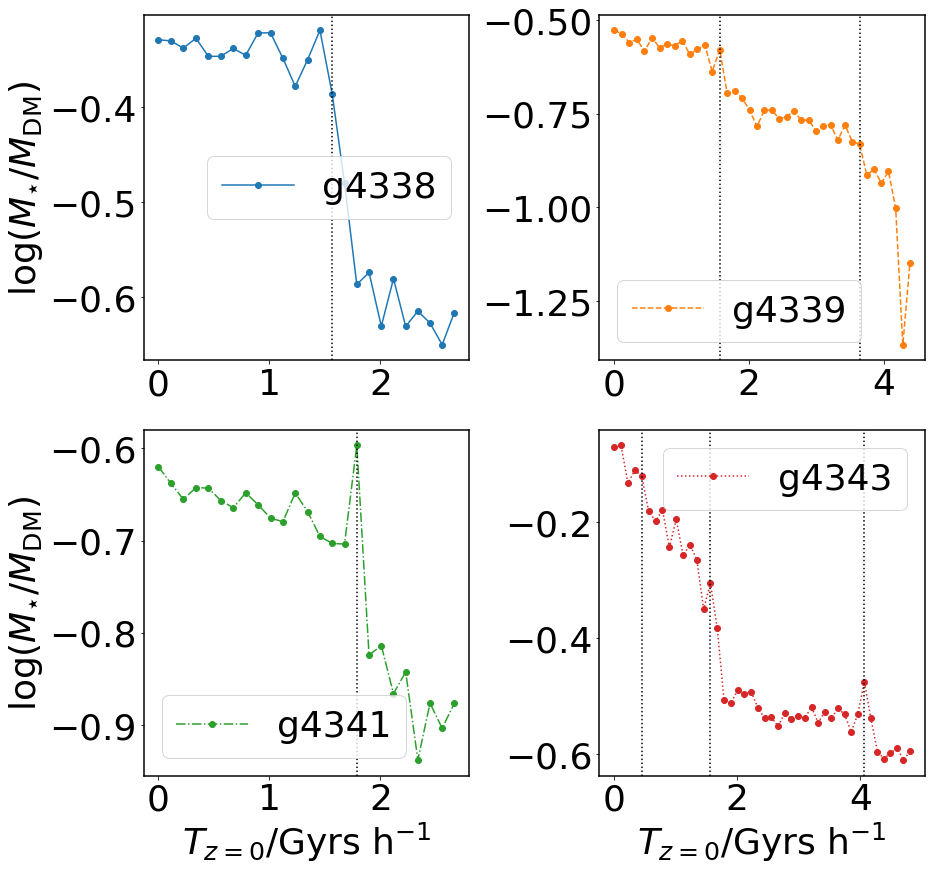

In [48]:
pl.figure(figsize=(14,14))

pl.subplots_adjust(wspace=.4)

pl.subplot(2, 2, 1)
pl.plot(Time_4338, np.log10(Smass_4338/DMmass_4338), marker='o', color='tab:blue', label='g4338', ls='-')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4338:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.ylabel('$\\log(M_{\\star}/M_{\\rm DM})$')

pl.subplot(2, 2, 2)
pl.plot(Time_4339, np.log10(Smass_4339/(DMmass_4339)), marker='o', color='tab:orange', label='g4339', ls='--')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4339:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.subplot(2, 2, 3)
pl.plot(Time_4341, np.log10(Smass_4341/(DMmass_4341)), marker='o', color='tab:green', label='g4341', ls='-.')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4341:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)
pl.ylabel('$\\log(M_{\\star}/M_{\\rm DM})$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')


pl.subplot(2, 2, 4)
pl.plot(Time_4343, np.log10(Smass_4343/(DMmass_4343)), marker='o', color='tab:red', label='g4343', ls=':')
ylim = pl.ylim()
for t in mtime_4343:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.legend(loc='best')

# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')

Text(0.5, 0, '$T_{z=0}$/Gyrs h$^{-1}$')

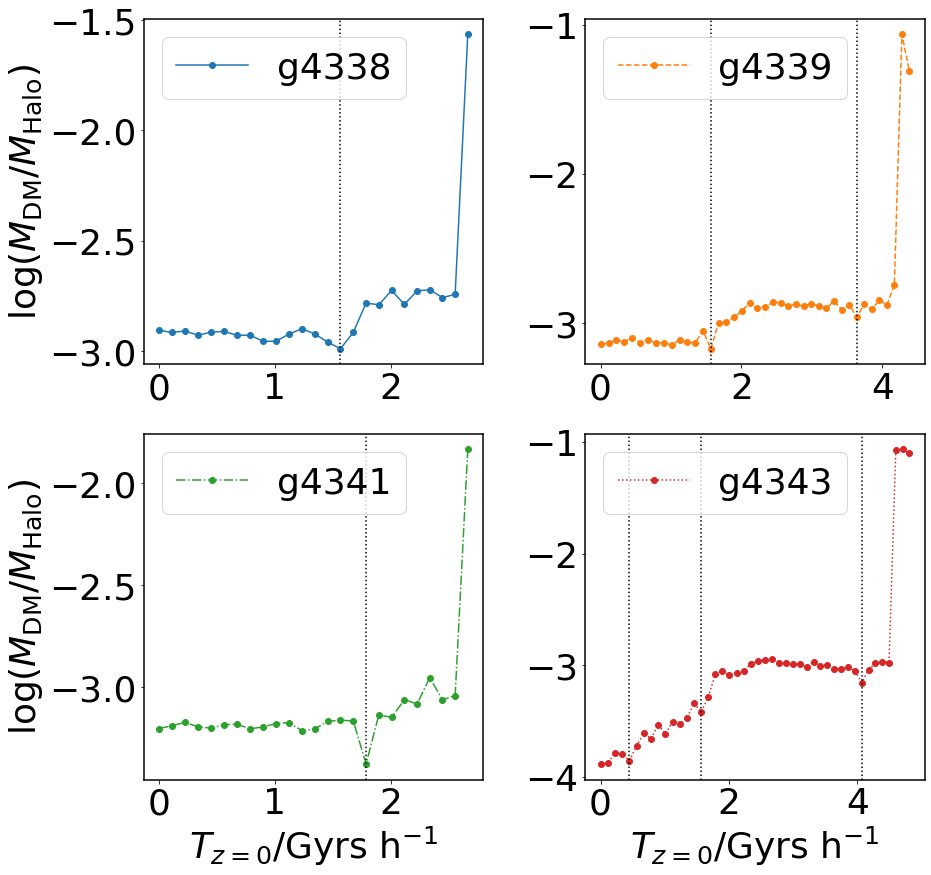

In [49]:
pl.figure(figsize=(14,14))

pl.subplots_adjust(wspace=.3)

pl.subplot(2, 2, 1)
pl.plot(Time_4338, np.log10(DMmass_4338/MHalo_4338), marker='o', color='tab:blue', label='g4338', ls='-')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4338:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.ylabel('$\\log(M_{\\rm DM}/M_{\\rm Halo})$')

pl.subplot(2, 2, 2)
pl.plot(Time_4339, np.log10(DMmass_4339/MHalo_4339), marker='o', color='tab:orange', label='g4339', ls='--')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4339:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.subplot(2, 2, 3)
pl.plot(Time_4341, np.log10(DMmass_4341/MHalo_4341), marker='o', color='tab:green', label='g4341', ls='-.')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4341:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)
pl.ylabel('$\\log(M_{\\rm DM}/M_{\\rm Halo})$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')


pl.subplot(2, 2, 4)
pl.plot(Time_4343, np.log10(DMmass_4343/MHalo_4343), marker='o', color='tab:red', label='g4343', ls=':')
ylim = pl.ylim()
for t in mtime_4343:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.legend(loc='best')

# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')

Text(0.5, 0, '$T_{z=0}$/Gyrs h$^{-1}$')

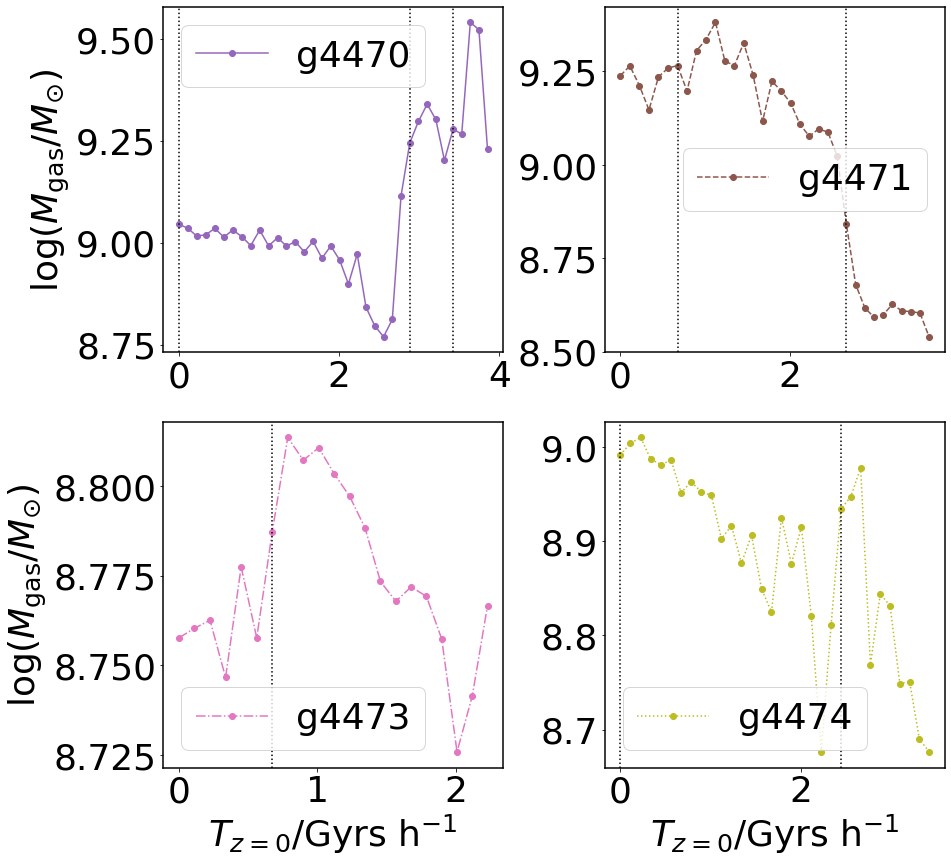

In [50]:
pl.figure(figsize=(14,14))
pl.subplots_adjust(wspace=.3)

pl.subplot(2, 2, 1)
pl.plot(Time_4470, np.log10(Gmass_4470), marker='o', color='tab:purple', label='g4470', ls='-')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4470:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.ylabel('$\\log(M_{\\rm gas}/M_{\\odot})$')

pl.subplot(2, 2, 2)
pl.plot(Time_4471, np.log10(Gmass_4471), marker='o', color='tab:brown', label='g4471', ls='--')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4471:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.subplot(2, 2, 3)
pl.plot(Time_4473, np.log10(Gmass_4473), marker='o', color='tab:pink', label='g4473', ls='-.')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4473:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)
# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.ylabel('$\\log(M_{\\rm gas}/M_{\\odot})$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')


pl.subplot(2, 2, 4)
pl.plot(Time_4474, np.log10(Gmass_4474), marker='o', color='tab:olive', label='g4474', ls=':')
ylim = pl.ylim()
for t in mtime_4474:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.legend(loc='best')

# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')

Text(0.5, 0, '$T_{z=0}$/Gyrs h$^{-1}$')

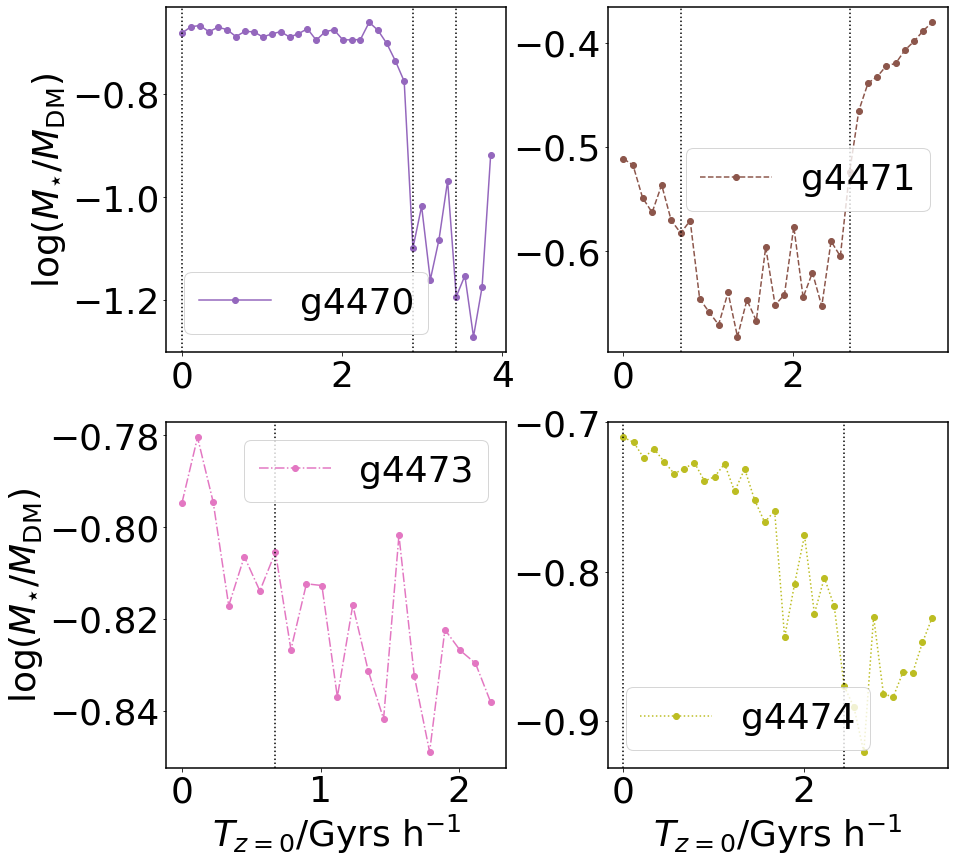

In [51]:
pl.figure(figsize=(14,14))
pl.subplots_adjust(wspace=.3)

pl.subplot(2, 2, 1)
pl.plot(Time_4470, np.log10(Smass_4470/DMmass_4470), marker='o', color='tab:purple', label='g4470', ls='-')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4470:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.ylabel('$\\log(M_{\\star}/M_{\\rm DM})$')

pl.subplot(2, 2, 2)
pl.plot(Time_4471, np.log10(Smass_4471/DMmass_4471), marker='o', color='tab:brown', label='g4471', ls='--')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4471:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.subplot(2, 2, 3)
pl.plot(Time_4473, np.log10(Smass_4473/DMmass_4473), marker='o', color='tab:pink', label='g4473', ls='-.')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4473:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)
# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.ylabel('$\\log(M_{\\star}/M_{\\rm DM})$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')


pl.subplot(2, 2, 4)
pl.plot(Time_4474, np.log10(Smass_4474/DMmass_4474), marker='o', color='tab:olive', label='g4474', ls=':')
ylim = pl.ylim()
for t in mtime_4474:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.legend(loc='best')

# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')

Text(0.5, 0, '$T_{z=0}$/Gyrs h$^{-1}$')

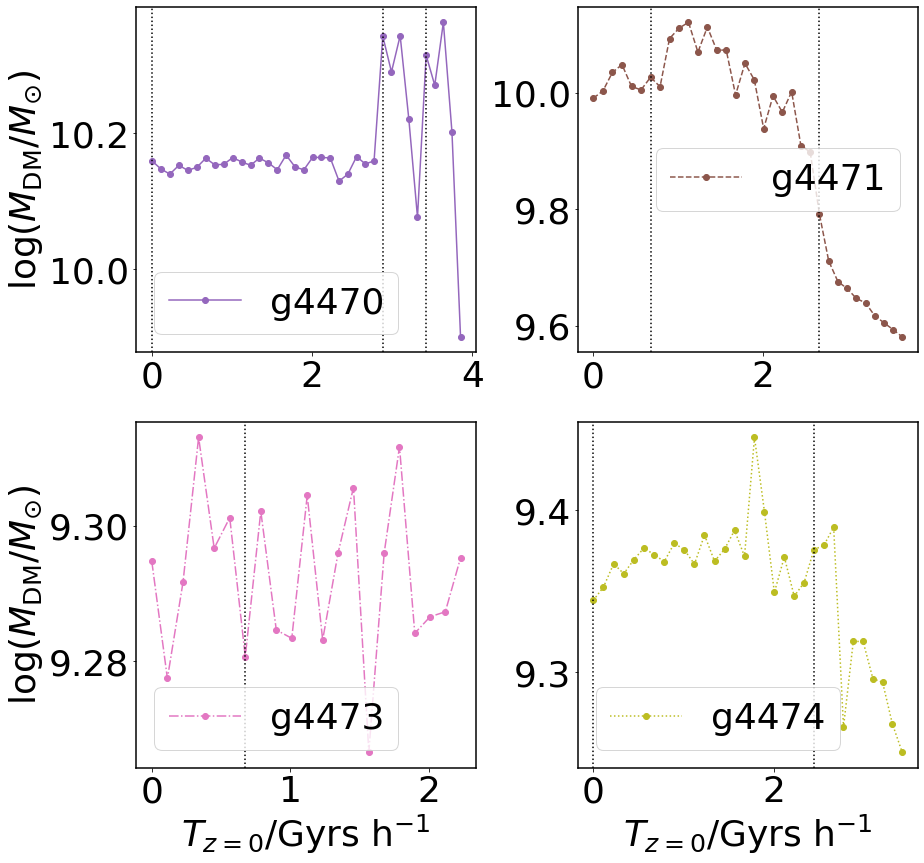

In [52]:
pl.figure(figsize=(14,14))
pl.subplots_adjust(wspace=.3)

pl.subplot(2, 2, 1)
pl.plot(Time_4470, np.log10(DMmass_4470), marker='o', color='tab:purple', label='g4470', ls='-')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4470:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.ylabel('$\\log(M_{\\rm DM}/M_{\\odot})$')

pl.subplot(2, 2, 2)
pl.plot(Time_4471, np.log10(DMmass_4471), marker='o', color='tab:brown', label='g4471', ls='--')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4471:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.subplot(2, 2, 3)
pl.plot(Time_4473, np.log10(DMmass_4473), marker='o', color='tab:pink', label='g4473', ls='-.')
pl.legend(loc='best')

ylim = pl.ylim()
for t in mtime_4473:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)
# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.ylabel('$\\log(M_{\\rm DM}/M_{\\odot})$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')


pl.subplot(2, 2, 4)
pl.plot(Time_4474, np.log10(DMmass_4474), marker='o', color='tab:olive', label='g4474', ls=':')
ylim = pl.ylim()
for t in mtime_4474:
    pl.plot([t, t], [ylim[0], ylim[1]], ls=':', color='black')
pl.ylim(ylim)

pl.legend(loc='best')

# pl.ylabel('$M_{\\rm gas}/M_{\star}$')
pl.xlabel('$T_{z=0}$/Gyrs h$^{-1}$')

In [53]:
sim['SnapNumber_128/SubGroups'].keys()

<KeysViewHDF5 ['Apertures', 'GroupNumber', 'OpticalRadius', 'PartType0', 'PartType1', 'PartType4', 'PartType5', 'SnapNumber', 'SubFindNumber', 'SubGroupHalfMass', 'SubGroupLen', 'SubGroupMostBoundID', 'SubGroupNumber', 'SubGroupPos', 'SubGroupSpin', 'SubGroupVel', 'SubGroupVelDisp', 'SubGroupVelMax']>

In [54]:
sim['SnapNumber_128/Groups/Group_M_Crit200'].attrs['description_units']

'$10^{10}  h^{-1} M_\\odot$'

In [55]:
def SnapMin(dist):
    i = []
    for j, d in enumerate(dist):
        if j!=0 and j!=dist.size-1:
            if d<dist[j+1] and d<dist[j-1]:
                i.append(j)
    i = np.array(i)
    il = i[-1]
    snlist = np.arange(128, 29, -1)
    return snlist[il], snlist[dist.size-1]

def VarGas(galID, dist):
    snapmin, snapmas = SnapMin(dist)
    
    uniqueID = int(128*1e6+galID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))

    for m in mtree:
        snap, ffT = split_unique_id(int(m))
        if snap == snapmin:
            offG = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][ffT].astype('int')
            massGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][offG[0]:offG[1]]
            MassPeri = np.sum(massGas)
        if snap == snapmas:
            offG = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][ffT].astype('int')
            massGas = sim['SnapNumber_{}/PartType0/Masses'.format(snap)][offG[0]:offG[1]]
            MassInit = np.sum(massGas)
    
    return MassPeri/MassInit

In [56]:
fperi_4338 = VarGas(4338, dist_4338)
fperi_4339 = VarGas(4339, dist_4339)
fperi_4341 = VarGas(4341, dist_4341)
fperi_4343 = VarGas(4343, dist_4343)

fperi_4470 = VarGas(4470, dist_4470)
fperi_4471 = VarGas(4471, dist_4471)
fperi_4473 = VarGas(4473, dist_4473)
fperi_4474 = VarGas(4474, dist_4474)

In [57]:
fperi_4338, fperi_4339, fperi_4341, fperi_4343

(0.35101506, 0.5271708, 0.3744877, 0.40757167)

In [58]:
fperi_4470, fperi_4471, fperi_4473, fperi_4474

(0.72035486, 0.5802826, 0.9139875, 0.8327038)